In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch

sys.path.append(os.path.join(os.getenv("HOME"), "RNN_Manifold/"))
import decode_1d, generate_1d, geometry_util

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device {}".format(device))

using device cuda


Generate some ring data

In [4]:
encoder, decoder, _ = generate_1d.train(1, 0, 12, device, n_training_iterations=3000)


/home/trevor/brainvenv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


iteration: 0, decoding loss: 1.5517640113830566, distance cost: 0.008236254565417767
iteration: 2, decoding loss: 1.4074033498764038, distance cost: 0.057744160294532776
iteration: 3, decoding loss: 1.042374610900879, distance cost: 0.09271028637886047
iteration: 4, decoding loss: 0.6171296834945679, distance cost: 0.09059052914381027
iteration: 5, decoding loss: 0.4992774724960327, distance cost: 0.05724865570664406
iteration: 6, decoding loss: 0.4375899136066437, distance cost: 0.027445374056696892
iteration: 12, decoding loss: 0.352074533700943, distance cost: 0.030880536884069443
iteration: 13, decoding loss: 0.33006757497787476, distance cost: 0.037962593138217926
iteration: 224, decoding loss: 0.341198593378067, distance cost: 0.024669308215379715
iteration: 227, decoding loss: 0.33812350034713745, distance cost: 0.025916345417499542
iteration: 229, decoding loss: 0.3335777223110199, distance cost: 0.029843579977750778
iteration: 250, decoding loss: 0.33583399653434753, distance 

In [5]:
angles = np.arange(start=0, stop=2 * np.pi, step=0.01)
with torch.no_grad():
    test_embedding = encoder(torch.tensor(np.expand_dims(angles, -1), dtype=torch.get_default_dtype()).to(device))
ring_embedded_points = test_embedding.cpu().numpy()

In [6]:
sample_indicies = np.random.choice(np.shape(ring_embedded_points)[0], 100)
test_ring_data = ring_embedded_points[sample_indicies, :]
test_ring_phases = angles[sample_indicies]

Form a simple torus as the product of two rings

In [7]:
possible_samples = np.arange(start=0, stop=np.shape(test_ring_data)[0], step=1)
possible_pairs = []
for sample_1 in possible_samples:
    for sample_2 in possible_samples:
        possible_pairs.append([sample_1, sample_2])

possible_pairs = np.array(possible_pairs)
n_samples = 1000
samples = np.random.choice(len(possible_pairs), n_samples)
indicies = possible_pairs[samples, :]

data_1 = test_ring_data[indicies[:, 0], :]
phases_1 = test_ring_phases[indicies[:, 0]]

data_2 = test_ring_data[indicies[:, 1], :]
phases_2 = test_ring_phases[indicies[:, 1]]

product_torus_data = np.concatenate([data_1, data_2], axis=1)
product_torus_data = product_torus_data/np.mean(np.abs(product_torus_data))
product_torus_phases = np.stack([phases_1, phases_2], axis=-1)

Decode the product torus

In [8]:
encoder, decoder, _ = decode_1d.train(data=product_torus_data, n_circular_dimensions=2, n_linear_dimensions=0, device=device,
                                                   n_training_iterations=3000, decoder_weight=10, order_red_weight=0.1)

/home/trevor/brainvenv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


iteration: 0, decoding loss: 1.354631781578064, distance cost: 0.019119400531053543, order reduction: 0.04739106819033623
iteration: 2, decoding loss: 0.6870517730712891, distance cost: 0.10100451856851578, order reduction: 0.047612037509679794
iteration: 3, decoding loss: 0.5073684453964233, distance cost: 0.025835447013378143, order reduction: 0.009010580368340015
iteration: 4, decoding loss: 0.4827340543270111, distance cost: 0.030850522220134735, order reduction: 0.16292954981327057
iteration: 5, decoding loss: 0.4359860122203827, distance cost: 0.03410772606730461, order reduction: 0.01049619261175394
iteration: 6, decoding loss: 0.3991599380970001, distance cost: 0.054927535355091095, order reduction: 0.08132891356945038
iteration: 7, decoding loss: 0.3790203928947449, distance cost: 0.061900634318590164, order reduction: 0.04708675667643547
iteration: 8, decoding loss: 0.3592604398727417, distance cost: 0.03744227811694145, order reduction: 0.08412902802228928
iteration: 9, deco

In [22]:
with torch.no_grad():
    product_predicted_phases = decoder(torch.tensor(product_torus_data, dtype=torch.get_default_dtype()).to(device)).cpu().numpy()

In [23]:
def compare_to_ground_truth(predicted_phases, ground_truth_phases, plot_axes):
    refd_test_phases = geometry_util.reference_periodic_phases(predicted_phases)
    refd_true_phases = geometry_util.reference_periodic_phases(ground_truth_phases)
    if np.abs(refd_test_phases[1,1] - refd_true_phases[1, 0]) < np.abs(refd_test_phases[1,1] - refd_true_phases[1, 1]):
        refd_test_phases = np.stack([refd_test_phases[:, 1], refd_test_phases[:, 0]], axis=-1)
    line = np.arange(start=-np.pi, stop=np.pi, step=0.01)
    plot_axes[0].scatter(refd_true_phases[:, 0], refd_test_phases[:, 0])
    plot_axes[0].plot(line, line, color="black", linestyle="--", label="y=x")
    plot_axes[1].scatter(refd_true_phases[:, 1], refd_test_phases[:, 1])
    plot_axes[1].plot(line, line, color="black", linestyle="--", label="y=x")
    plot_axes[0].set_xlabel("True Phase")
    plot_axes[0].set_title("Phase 1")
    plot_axes[1].set_xlabel("True Phase")
    plot_axes[1].set_title("Phase 2")
    plot_axes[0].set_ylabel("Found Phase")
    return refd_test_phases, refd_true_phases

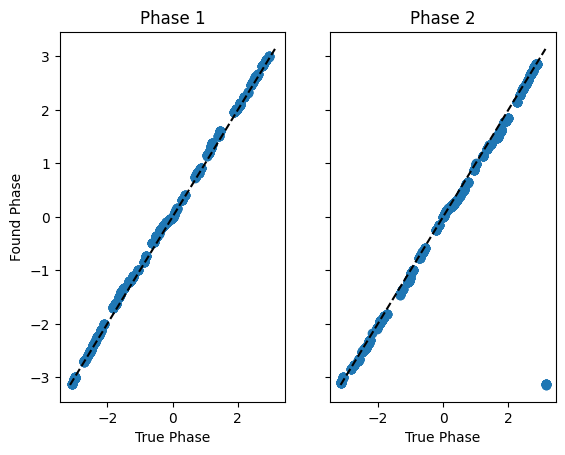

In [24]:
fig, axs = plt.subplots(ncols=2, sharey=True)
referenced_product_predicted_phases, referenced_product_true_phases = compare_to_ground_truth(product_predicted_phases, product_torus_phases, axs)

Make a torus directly using the generative model

In [26]:
encoder, decoder, _ = generate_1d.train(n_circular_dimensions=2, n_linear_dimensions=0, embedding_dimension=12, device=device, n_training_iterations=5000)

iteration: 0, decoding loss: 2.3897969722747803, distance cost: 0.017029454931616783
iteration: 1, decoding loss: 2.20536470413208, distance cost: 0.0040526925586164
iteration: 2, decoding loss: 1.1729884147644043, distance cost: 0.007778712082654238
iteration: 3, decoding loss: 0.9868035912513733, distance cost: 0.01500045694410801
iteration: 4, decoding loss: 0.9764696359634399, distance cost: 0.021222637966275215
iteration: 8, decoding loss: 0.9102658033370972, distance cost: 0.04752865061163902
iteration: 34, decoding loss: 0.896358072757721, distance cost: 0.046744342893362045
iteration: 67, decoding loss: 0.8563447594642639, distance cost: 0.08448947966098785
iteration: 69, decoding loss: 0.8154423236846924, distance cost: 0.08963707089424133
iteration: 72, decoding loss: 0.7989755272865295, distance cost: 0.08363524079322815
iteration: 186, decoding loss: 0.8238298892974854, distance cost: 0.048475589603185654
iteration: 187, decoding loss: 0.8078127503395081, distance cost: 0.0

In [29]:
torus_phases = np.random.uniform(0, 2 * np.pi, (1000, 2))
with torch.no_grad():
    torus_embedded_points = encoder(torch.tensor(torus_phases, dtype=torch.get_default_dtype()).to(device))
torus_embedded_points = torus_embedded_points.cpu().numpy()

Decode the generated torus

In [30]:
normed_torus_embedded_points = torus_embedded_points/np.mean(np.abs(torus_embedded_points))

In [32]:
encoder, decoder, _ = decode_1d.train(data=normed_torus_embedded_points, n_circular_dimensions=2, n_linear_dimensions=0, device=device,
                                                   n_training_iterations=3000, decoder_weight=10, order_red_weight=0.1)


iteration: 0, decoding loss: 1.508437991142273, distance cost: 0.08826418220996857, order reduction: 0.03264062479138374
iteration: 2, decoding loss: 0.9273873567581177, distance cost: 0.11318305134773254, order reduction: 0.022360268980264664
iteration: 3, decoding loss: 0.8488335609436035, distance cost: 0.10662302374839783, order reduction: 0.013316940516233444
iteration: 4, decoding loss: 0.636948823928833, distance cost: 0.043889157474040985, order reduction: 0.010175525210797787
iteration: 5, decoding loss: 0.6358059644699097, distance cost: 0.0341278500854969, order reduction: 0.009709390811622143
iteration: 6, decoding loss: 0.6134587526321411, distance cost: 0.044446881860494614, order reduction: 0.010497388429939747
iteration: 7, decoding loss: 0.555235743522644, distance cost: 0.04547101631760597, order reduction: 0.010836311616003513
iteration: 8, decoding loss: 0.47497549653053284, distance cost: 0.04320402815937996, order reduction: 0.00956736784428358
iteration: 9, decod

In [35]:
with torch.no_grad():
    gen_predicted_phases = decoder(torch.tensor(normed_torus_embedded_points, dtype=torch.get_default_dtype()).to(device)).cpu().numpy()

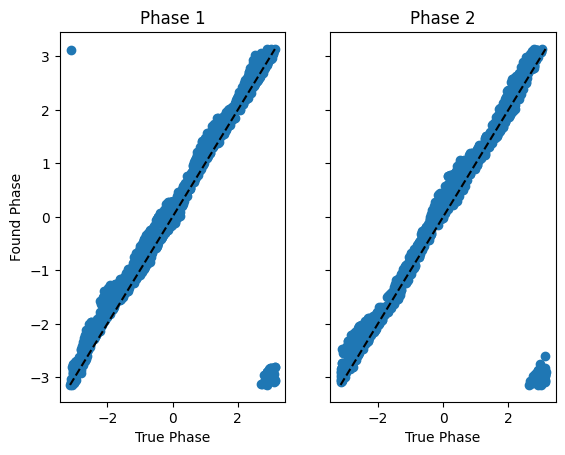

In [36]:
fig, axs = plt.subplots(ncols=2, sharey=True)
referenced_gen_predicted_phases, referenced_gen_true_phases = compare_to_ground_truth(gen_predicted_phases, torus_phases, axs)
